# Final Project (Music Data)

## IMPORTANT: This is an extra dataset alongside the three from UCI. One of the files is too big so it needs to be downloaded for this dataset to work.  features.csv needs to be extracted from the file link in https://github.com/mdeff/fma into the /fma_metadata folder in order for this notebook to work

### Load Libraries

In [1]:
import scipy.io as sio
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import tree
from sklearn import svm
from sklearn import ensemble
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from IPython.display import Markdown as md

c:\python36\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
# heatmap function
def draw_heatmap_linear(acc, acc_desc, param_list):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(acc, annot=True, fmt='.3f', yticklabels=param_list, xticklabels=[])
    ax.collections[0].colorbar.set_label("accuracy")
    ax.set(ylabel='parameter')
    plt.title(acc_desc + ' w.r.t parameter')
    sns.set_style("whitegrid", {'axes.grid' : False})
    plt.show()

### Load FMA dataset

In [15]:
a = [2]

with open('fma_metadata/features.csv') as fd:
    for n, line in enumerate(fd):
        if n in a:
            myline = line.strip()
            
numerical = ','.join(myline.split(',')[1:])
rough = np.fromstring(numerical, dtype=int, sep=',')
colinds = [i+1 for i, x in enumerate(rough==1) if x]
print(colinds)

[1, 13, 25, 37, 49, 61, 73, 85, 97, 109, 121, 133, 145, 157, 169, 181, 193, 205, 217, 229, 241, 253, 273, 293, 313, 333, 353, 373, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 421, 428, 435, 442, 449, 456, 463, 464, 465, 466, 467, 468, 469, 470, 476, 482, 488, 494, 500, 506, 512, 513, 514, 515, 516, 517, 518]


In [16]:
rows = []
with open('fma_metadata/id_genre.csv', encoding='utf-8') as fd:
    for n, line in enumerate(fd):
        try:
            l = line.strip()
            int(l[0])
            genre = l.split(',')[1]
            rows.append(genre)
        except:
            pass
categ = np.array(rows)
print(categ.shape)   
print(categ[0:15])

(106574,)
['Hip-Hop' 'Hip-Hop' 'Hip-Hop' 'Pop' '' '' '' '' '' 'Hip-Hop' 'Rock'
 'Rock' 'Experimental' 'Experimental' 'Folk']


In [17]:
%%time
# colinds.insert(0,0)
# colinds2 = [0,1]
attr = np.loadtxt('fma_metadata/features.csv', delimiter=',', usecols=(colinds[:20]), skiprows=4)
# categ = np.loadtxt('fma_metadata/id_genre.csv', delimiter=',', usecols=(colinds2), dtype=object)

# categ_id = categ[:,0].astype(int)
# attr_id = attr[:,0].astype(int)
# yes_tracks = np.isin(categ_id, attr_id)

# rowinds = [i for i, x in enumerate(res_tracks) if x]

# categ = categ[rowinds,1]
# attr = attr[:,1:]

print(attr.shape)
print(categ.shape)

# cut down dataset to 20%
inds = np.linspace(0,len(categ)-1, 30000).astype(int)
attr = attr[inds]
categ = categ[inds]

# change categ to binary
new_categ = [(1 if val=='Rock' else 0) for val in categ]
categ = np.array(new_categ)

rock = np.sum(categ)
total = len(categ)
print('{0} out of {1} or {2}% of songs are Rock.'.format(rock, total, rock/total*100))

(106574, 20)
(106574,)
4006 out of 30000 or 13.353333333333333% of songs are Rock.
Wall time: 12.3 s


In [9]:
# create shuffled dataset
def shuffle_data(attr, categ):
    # creates 3 shuffled sets of 20-20, 50-50, 80-20
    curr_set = {'twenty':{'train':{},'test':{}},'fifty':{'train':{},'test':{}},'eighty':{'train':{},'test':{}}}
    
    # index shuffling
    set_l = 15000
    ind_ord = np.arange(0,set_l)
    np.random.shuffle(ind_ord)
    
    # 20%-80%
    curr_set['twenty']['train'] = {'type':categ[ind_ord[:int(set_l*.2)]], 'feat':attr[ind_ord[:int(set_l*.2)],:]}
    curr_set['twenty']['test'] = {'type':categ[ind_ord[int(set_l*.2):]], 'feat':attr[ind_ord[int(set_l*.2):],:]}

    # 50%-50%
    curr_set['fifty']['train'] = {'type':categ[ind_ord[:int(set_l*.5)]], 'feat':attr[ind_ord[:int(set_l*.5)],:]}
    curr_set['fifty']['test'] = {'type':categ[ind_ord[int(set_l*.5):]], 'feat':attr[ind_ord[int(set_l*.5):],:]}

    # 80%-20%
    curr_set['eighty']['train'] = {'type':categ[ind_ord[:int(set_l*.8)]], 'feat':attr[ind_ord[:int(set_l*.8)],:]}
    curr_set['eighty']['test'] = {'type':categ[ind_ord[int(set_l*.8):]], 'feat':attr[ind_ord[int(set_l*.8):],:]}
    
    return curr_set

### Boosted Trees (BST-DT)

In [38]:
# set prep (music)
music_sets = shuffle_data(attr, categ)
sets = [];
sets.append(music_sets['twenty']);
sets.append(music_sets['fifty']);
sets.append(music_sets['eighty']);
desc = ['20-80', '50-50', '80-20']

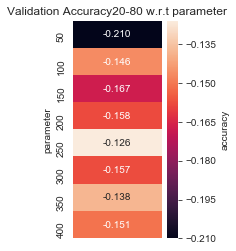

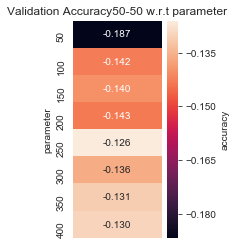

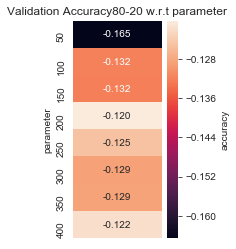

Wall time: 1h 11min 9s


In [42]:
%%time
# Hyper-Parameter Selection: max number of estimators
clf = ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor())
n_estimators = [50, 100, 150, 200, 250, 300, 350, 400]

gridsearch = GridSearchCV(clf, {'n_estimators': n_estimators}, cv = 5)

# reduce setsize for gridsearch by 20%
setr = []
for seti in sets:
    seti_l = int(len(seti['train']['type'])*.2)
    seti_l2 = int(len(seti['test']['type'])*.2)
    tempset = {'train': { 'feat': seti['train']['feat'][:seti_l,:],
                        'type': seti['train']['type'][:seti_l]},
               'test': { 'feat': seti['test']['feat'][:seti_l2,:],
                        'type': seti['test']['type'][:seti_l2]}}
    setr.append(tempset)

counter = 0
for seti in sets:
    gridsearch.fit(seti['train']['feat'], seti['train']['type'].ravel())
    val_acc = np.array(gridsearch.cv_results_['mean_test_score'])
    
    draw_heatmap_linear(val_acc.reshape(8,1), 'Validation Accuracy'+desc[counter], n_estimators)
    counter+=1

In [43]:
%%time
best_n_estimator = [250, 250, 200]
best_val_acc = [0, 0, 0]
best_train_acc = [0, 0, 0]
best_test_acc = [0, 0, 0]

num_trials = 3
for trial in range(num_trials):
    counter = 0
    
    # reshuffle data
    music_sets = shuffle_data(attr, categ)
    sets = [];
    sets.append(music_sets['twenty']);
    sets.append(music_sets['fifty']);
    sets.append(music_sets['eighty']);
    
    for seti in sets:
        clf = ensemble.AdaBoostRegressor(tree.DecisionTreeRegressor(), n_estimators = best_n_estimator[counter])
        scores = cross_validate(clf, seti['train']['feat'], seti['train']['type'].ravel(), cv=5)
        train_acc = np.mean(scores['train_score'])
        val_acc = np.mean(scores['test_score'])
        fitting = clf.fit(seti['train']['feat'], seti['train']['type'].ravel())
        test_acc = fitting.score(seti['test']['feat'], seti['test']['type'].ravel())
        best_train_acc[counter] += train_acc/num_trials
        best_val_acc[counter] += val_acc/num_trials
        best_test_acc[counter] += test_acc/num_trials
        counter +=1

c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score (

Wall time: 35min 21s


In [44]:
# generate latex table
table = '\\begin{tabular}{|c | c c c |}\n'
table += '\\hline\n'
table += '& 20\%-80\% & 50\%-50\% & 80\%-20\%\\\\\n\\hline\\\n'
table += 'Max Estimators & $'+'$ & $'.join('%.3f'%x for x in best_n_estimator) + '$\\\\\n'
table += 'Training Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_train_acc) + '$\\\\\n'
table += 'Validation Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_val_acc) + '$\\\\\n'
table += 'Testing Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_test_acc) + '$\\\\\n\\hline\n'
table += '\\end{tabular}'
print(table)

\begin{tabular}{|c | c c c |}
\hline
& 20\%-80\% & 50\%-50\% & 80\%-20\%\\
\hline\
Max Estimators & $250.000$ & $250.000$ & $200.000$\\
Training Accuracy & $1.000$ & $1.000$ & $1.000$\\
Validation Accuracy & $-0.170$ & $-0.134$ & $-0.125$\\
Testing Accuracy & $-0.168$ & $-0.129$ & $-0.098$\\
\hline
\end{tabular}


![(ACC) for (BST-DT) on FMA](table7.svg)

### Support Vector Machine (SVM)

In [10]:
# set prep (music)
music_sets = shuffle_data(attr, categ)
sets = [];
sets.append(music_sets['twenty']);
sets.append(music_sets['fifty']);
sets.append(music_sets['eighty']);
desc = ['20-80', '50-50', '80-20']

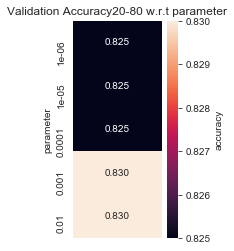

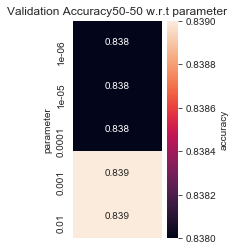

In [ ]:
%%time
# Hyper-Parameter Selection: regularization
clf = svm.SVC(kernel='linear')
# regularization = [10e-7, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10e0, 10e1, 10e2, 10e3]
regularization = [10e-7, 10e-6, 10e-5, 10e-4, 10e-3]

gridsearch = GridSearchCV(clf, {'C': regularization}, cv = 3)

# reduce setsize for gridsearch by 10%
setr = []
for seti in sets:
    seti_l = int(len(seti['train']['type'])*.1)
    seti_l2 = int(len(seti['test']['type'])*.1)
    tempset = {'train': { 'feat': seti['train']['feat'][:seti_l,:],
                        'type': seti['train']['type'][:seti_l]},
               'test': { 'feat': seti['test']['feat'][:seti_l2,:],
                        'type': seti['test']['type'][:seti_l2]}}
    setr.append(tempset)

counter = 0
for seti in setr:
    gridsearch.fit(seti['train']['feat'], seti['train']['type'].ravel())
    val_acc = np.array(gridsearch.cv_results_['mean_test_score'])
    
    draw_heatmap_linear(val_acc.reshape(5,1), 'Validation Accuracy'+desc[counter], regularization)
    counter+=1

In [11]:
%%time
best_regularizer = [.001, .001, .0001]
best_val_acc = [0, 0, 0]
best_train_acc = [0, 0, 0]
best_test_acc = [0, 0, 0]

num_trials = 3
for trial in range(num_trials):
    counter = 0
    
    # reshuffle data
    music_sets = shuffle_data(attr, categ)
    sets = [];
    sets.append(music_sets['twenty']);
    sets.append(music_sets['fifty']);
    sets.append(music_sets['eighty']);
    
    for seti in sets:
        clf = svm.SVC(kernel='linear', C=best_regularizer[counter])
        scores = cross_validate(clf, seti['train']['feat'], seti['train']['type'].ravel(), cv=5)
        train_acc = np.mean(scores['train_score'])
        val_acc = np.mean(scores['test_score'])
        fitting = clf.fit(seti['train']['feat'], seti['train']['type'].ravel())
        test_acc = fitting.score(seti['test']['feat'], seti['test']['type'].ravel())
        best_train_acc[counter] += train_acc/num_trials
        best_val_acc[counter] += val_acc/num_trials
        best_test_acc[counter] += test_acc/num_trials
        counter +=1

c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score (

Wall time: 58.4 s


In [12]:
# generate latex table
table = '\\begin{tabular}{| c | c c c |}\n'
table += '\\hline\n'
table += '& 20\%-80\% & 50\%-50\% & 80\%-20\%\\\\\n\\hline\n'
table += 'Best Regularizer & $'+'$ & $'.join('%.3f'%x for x in best_regularizer) + '$\\\\\n'
table += 'Training Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_train_acc) + '$\\\\\n'
table += 'Validation Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_val_acc) + '$\\\\\n'
table += 'Testing Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_test_acc) + '$\\\\\n\\hline\n'
table += '\\end{tabular}'
print(table)

\begin{tabular}{| c | c c c |}
\hline
& 20\%-80\% & 50\%-50\% & 80\%-20\%\\
\hline
Best Regularizer & $0.001$ & $0.001$ & $0.000$\\
Training Accuracy & $0.865$ & $0.865$ & $0.866$\\
Validation Accuracy & $0.865$ & $0.865$ & $0.866$\\
Testing Accuracy & $0.866$ & $0.866$ & $0.865$\\
\hline
\end{tabular}


![(ACC) for (SVM) on FMA](table8.svg)

### K Nearest Neighbors (KNN)

In [18]:
# set prep (music)
music_sets = shuffle_data(attr, categ)
sets = [];
sets.append(music_sets['twenty']);
sets.append(music_sets['fifty']);
sets.append(music_sets['eighty']);
desc = ['20-80', '50-50', '80-20']

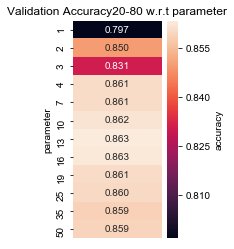

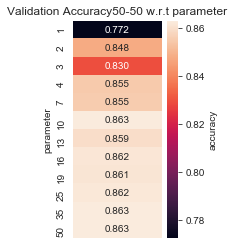

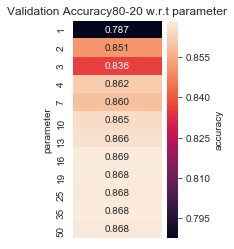

Wall time: 36 s


In [14]:
%%time
# Hyper-Parameter Selection: number of neighbors
clf = neighbors.KNeighborsClassifier()
n_neighbors = [1, 2, 3, 4, 7, 10, 13, 16, 19, 25, 35, 50]

# reduce setsize for gridsearch by 50%
setr = []
for seti in sets:
    seti_l = int(len(seti['train']['type'])*.5)
    seti_l2 = int(len(seti['test']['type'])*.5)
    tempset = {'train': { 'feat': seti['train']['feat'][:seti_l,:],
                        'type': seti['train']['type'][:seti_l]},
               'test': { 'feat': seti['test']['feat'][:seti_l2,:],
                        'type': seti['test']['type'][:seti_l2]}}
    setr.append(tempset)

counter = 0
for seti in setr:
    
    gridsearch = GridSearchCV(clf, {'n_neighbors': n_neighbors}, cv = 5)
    
    gridsearch.fit(seti['train']['feat'], seti['train']['type'].ravel())
    val_acc = np.array(gridsearch.cv_results_['mean_test_score'])
    
    draw_heatmap_linear(val_acc.reshape(12,1), 'Validation Accuracy'+desc[counter], n_neighbors)
    counter+=1

In [19]:
%%time
best_k = [13, 10, 10]
best_val_acc = [0, 0, 0]
best_train_acc = [0, 0, 0]
best_test_acc = [0, 0, 0]

num_trials = 3
for trial in range(num_trials):
    counter = 0
    
    # reshuffle data
    music_sets = shuffle_data(attr, categ)
    sets = [];
    sets.append(music_sets['twenty']);
    sets.append(music_sets['fifty']);
    sets.append(music_sets['eighty']);
    
    for seti in sets:
        clf = neighbors.KNeighborsClassifier(n_neighbors=best_k[counter])
        scores = cross_validate(clf, seti['train']['feat'], seti['train']['type'].ravel(), cv=5)
        train_acc = np.mean(scores['train_score'])
        val_acc = np.mean(scores['test_score'])
        fitting = clf.fit(seti['train']['feat'], seti['train']['type'].ravel())
        test_acc = fitting.score(seti['test']['feat'], seti['test']['type'].ravel())
        best_train_acc[counter] += train_acc/num_trials
        best_val_acc[counter] += val_acc/num_trials
        best_test_acc[counter] += test_acc/num_trials
        counter +=1

c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
c:\python36\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score (

Wall time: 28 s


In [20]:
# generate latex table
table = '\\begin{tabular}{| c | c c c |}\n'
table += '\\hline\n'
table += '& 20\%-80\% & 50\%-50\% & 80\%-20\%\\\\\n\\hline\n'
table += 'Best K Neighbors & $'+'$ & $'.join('%.3f'%x for x in best_k) + '$\\\\\n'
table += 'Training Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_train_acc) + '$\\\\\n'
table += 'Validation Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_val_acc) + '$\\\\\n'
table += 'Testing Accuracy & $'+'$ & $'.join('%.3f'%x for x in best_test_acc) + '$\\\\\n\\hline\n'
table += '\\end{tabular}'
print(table)

\begin{tabular}{| c | c c c |}
\hline
& 20\%-80\% & 50\%-50\% & 80\%-20\%\\
\hline
Best K Neighbors & $13.000$ & $10.000$ & $10.000$\\
Training Accuracy & $0.828$ & $0.837$ & $0.838$\\
Validation Accuracy & $0.814$ & $0.826$ & $0.825$\\
Testing Accuracy & $0.825$ & $0.826$ & $0.828$\\
\hline
\end{tabular}


![(ACC) for (KNN) on FMA](table9.svg)